
# Natural Language Processing

Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. Challenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation.

In this notebook, we discuss a higher level overview of the basics of NLP, which basically consists of combining basic machine learning techniques with text in a format that the machine learning algorithms can understand. 

In the future, we will talk about the state-of-the-art techniques for NLP using deep learning.
    
**Requirements:** You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, **run the code below in terminal:** ``conda install nltk``

In [1]:
# Import the library
import nltk 
import pandas as pd

## SMS Spam Collection Data Set

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The file we are using contains a collection of more than 5000 SMS phone messages. You can check out the **readme** file for more info.
We use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [2]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using **enumerate**:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print()

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

1 ham	Ok lar... Joking wif u oni...

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

3 ham	U dun say so early hor... U c already then say...

4 ham	Nah I don't think he goes to usf, he lives around here though

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

6 ham	Even my brother is not like to speak with me. They treat me like aids patent.

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. V

Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) (tab separated values) file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

We'll use ``read_csv`` and make note of the ``sep`` argument, we can also specify the desired column names by passing in a list of ``names``.

In [4]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Convert string labels into binary encodings, ``ham``= 0 and ``spam`` = 1:

In [5]:
df['label'] = pd.get_dummies(df['label'],drop_first=True)
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [6]:
print('There are', df['label'].value_counts()[0] ,'hams,', round(df['label'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('There are', df['label'].value_counts()[1] ,'spams,', round(df['label'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

There are 4825 hams, 86.59 % of the dataset
There are 747 spams, 13.41 % of the dataset


In [7]:
df.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Let's use ``groupby`` to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [8]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        4825   4516                             Sorry, I'll call later   30
1         747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. 

Let's make a new column to detect how long the text messages are:

In [9]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

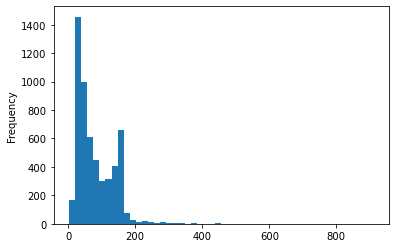

In [11]:
df['length'].plot(bins=50, kind='hist') 

In [12]:
df.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

The longest message contains 910 characters, we can use masking to find this message:

In [13]:
df[df['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Let's see if message length is a distinguishing feature between ham and spam:

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

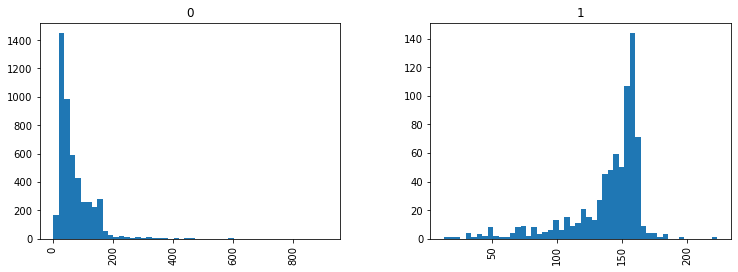

In [14]:
df.hist(column='length', by='label', bins=50,figsize=(12,4))

This suggests spam messages tend to have more characters. We are going to take the message length as one of the features.

## Text Preprocessing

The main issue is that the data is all in text format (strings). There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


Here we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

Firstly, we write a function that will split a message into its individual words and return a list. We'll also remove very common words ('the', 'a', etc..). **Stop words** are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information. To do this we will take advantage of the NLTK library. It's a standard library in Python for processing text and has a lot of useful features. We can just use ``apply()`` in Pandas do process all the text in the ``DataFrame``. We can just take advantage of Python's built-in ``string`` library to get a quick list of all the possible punctuation:

In [15]:
import string

In [16]:
mess = 'Sample message. Notice: it has punctuation.'

print(mess)

Sample message. Notice: it has punctuation.


In [17]:
# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

print(nopunc)

Sample message Notice it has punctuation


Now let's see how to remove stopwords. Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/py253733/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [20]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [22]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [23]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Put both of these together in a function `text_process` to apply it to our DataFrame later on:

In [24]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [25]:
df.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

In [26]:
# Check to make sure its working
df['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the one dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Word 1 Count</th> <th>Word 2 Count</th> <th>...</th> <th>Word N Count</th> 
</tr>
<tr>
<td><b>Message 1 </b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Message 2</b></td><td>0</td><td>0</td><td>...</td><td>1</td>
</tr>
<tr>
<td><b> $\vdots$ </b></td> <td> $\vdots$</td><td>$\vdots$</td><td>...</td><td>$\vdots$</td>
</tr>
<tr>
<td><b>Message M</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [28]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [29]:
message4 = df['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation:

In [30]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are 7 unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. We go ahead and check which ones appear twice:

In [31]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


/Users/py253733/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now we can use ``transform`` on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [32]:
messages_bow = bow_transformer.transform(df['message'])

In [33]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [34]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {:f}% non zero entries'.format(sparsity))

sparsity: 0.079403% non zero entries


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.


### TF-IDF
TF-IDF stands for **term frequency-inverse document frequency**, and the TF-IDF weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the TF-IDF weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the TF-IDF for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), a.k.a. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to **weigh down the frequent terms while scale up the rare ones**, by computing the following: 

*IDF(t) = log (Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the TF-IDF weight is the product of these quantities: 0.03 * 4 = 0.12.

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We can check the IDF (inverse document frequency) of the word `"u"` and of word `"university"`

In [36]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [37]:
message_tfidf = tfidf_transformer.transform(messages_bow)
print(message_tfidf.shape)

(5572, 11425)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". 

## Classification

With messages represented as vectors, we can finally train our spam/ham classifier. We can actually use almost any sort of classification algorithms.

We'll be using XGBoost classifier here:

In [38]:
from xgboost import XGBClassifier

### Train-Test Split

[``StratifiedShuffledSplit``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?highlight=stratified#sklearn.model_selection.StratifiedShuffleSplit) provides train/test indices to split data in train/test sets. This cross-validation object **preserves the orignal percentage of samples for each class after splitting.**

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
X = df['message']
y = df['label']

In [41]:
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 0)

for train_index, test_index in sss.split(X, y):
    print('# train samples:' , len(train_index) , ' Train index:', train_index)
    print('# test samples:' , len(test_index), ' Test index:', test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# train samples: 4457  Train index: [1257 5461 1613 ...  245 1235 3361]
# test samples: 1115  Test index: [2461  461 2628 ... 3681 2895 3100]


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

### Creating a Data Pipeline

Let's run our model again and then predict for the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow:

In [42]:
from sklearn.pipeline import Pipeline

In [43]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=101))  
    # train on TF-IDF vectors w/ XGBoost classifier
])

Now we can directly pass message text data and the pipeline will do the pre-processing. We can treat it as a model/estimator API:

In [44]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f91cd0f3280>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=101, reg_alpha=0,
                               reg_lambda=1, ...))])

###  Model Evaluation

Now we want to determine how well our model will do overall on the entire dataset. 

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" (false positives) is probably much lower than mis-predicting "ham" as "spam" (false negatives).

In [45]:
pred_train = pipeline.predict(X_train)

In [46]:
print('predicted:', pred_train[1])
print('expected:', y_train.iloc[1])

predicted: 0
expected: 0


In [47]:
from sklearn.metrics import classification_report

In [48]:
print('Train:\n', classification_report(pred_train, y_train))

Train:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3910
           1       0.91      1.00      0.95       547

    accuracy                           0.99      4457
   macro avg       0.96      0.99      0.97      4457
weighted avg       0.99      0.99      0.99      4457



Train:



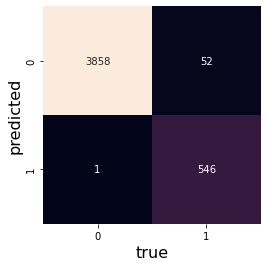

In [49]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train, pred_train)
print('Train:\n')
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16);

Now we have a classification report for our model on a test set.

In [50]:
pred_test = pipeline.predict(X_test)

In [52]:
print('Test:\n', classification_report(pred_test, y_test))

Test:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1002
           1       0.75      0.99      0.85       113

    accuracy                           0.97      1115
   macro avg       0.88      0.98      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [53]:
from sklearn.metrics import confusion_matrix

Test:



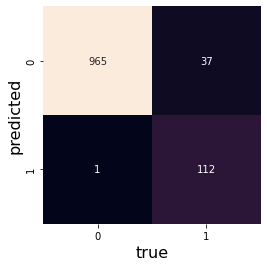

In [54]:
mat = confusion_matrix(y_test, pred_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
print('Test:\n')
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16);

### GridSearchCV

Let's try to use ``GridSearchCV`` to imporve the model's performance. We use ``'precision'`` for scoring, as it is less desirable misclassifying ``ham`` as ``spam`` than ``spam`` as ``ham``.

In [55]:
from sklearn.model_selection import GridSearchCV

We need to replace ``XGBClassifier`` with its ``GridSearchCV`` counterpart when creating pipeline.

In [79]:
param_grid = {'n_estimators': [50, 100, 300],
             'learning_rate': [0.05, 0.1, 0.3],
             'colsample_bytree': [0.8, 1],
              
             }
grid = GridSearchCV(XGBClassifier(booster='gbtree', objective='binary:logistic'), \
                    param_grid, cv=5, scoring = 'precision', verbose = 3, refit = True)

In [80]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', grid)  # train on TF-IDF vectors
])

In [81]:
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=50;, score=0.940 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=50;, score=0.965 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=50;, score=0.910 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=50;, score=0.986 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=50;, score=0.963 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=100;, score=0.966 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=100;, score=0.947 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=100;, score=0.919 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=100;, score=0.988 total time=   0.3s

[CV 5/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=50;, score=0.959 total time=   0.3s
[CV 1/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=100;, score=0.959 total time=   0.5s
[CV 2/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=100;, score=0.917 total time=   0.4s
[CV 3/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=100;, score=0.940 total time=   0.4s
[CV 4/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=100;, score=0.961 total time=   0.4s
[CV 5/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=100;, score=0.960 total time=   0.4s
[CV 1/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=300;, score=0.950 total time=   1.2s
[CV 2/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=300;, score=0.917 total time=   0.5s
[CV 3/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=300;, score=0.941 total time=   1.0s
[CV 4/5] END colsample_bytree=1, learning_rate=0.3, n_estimators=300;, score=0.941 

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7ff2530f63a0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metr...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...),
                              param_grid={'colsample_bytree': [0.8, 1],
                                          'learning_rate': [0.05, 0.1, 0.3],
                                          'n_estimators': [50, 100, 300]},
                              scoring='precision', verbose=3))])

In [82]:
print(grid.best_params_)

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'n_estimators': 300}


Now evaluate:

In [83]:
pred_train = pipeline.predict(X_train)

In [84]:
print('Train:\n', classification_report(pred_train, y_train))

Train:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3928
           1       0.88      1.00      0.94       529

    accuracy                           0.98      4457
   macro avg       0.94      0.99      0.96      4457
weighted avg       0.99      0.98      0.98      4457



Train:



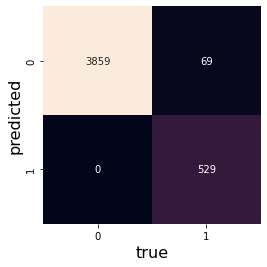

In [85]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train, pred_train)
print('Train:\n')
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16);

Now we have a classification report for our model on a test set.

In [86]:
pred_test = pipeline.predict(X_test)

In [87]:
print('Test:\n', classification_report(pred_test, y_test))

Test:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1007
           1       0.71      0.98      0.82       108

    accuracy                           0.96      1115
   macro avg       0.85      0.97      0.90      1115
weighted avg       0.97      0.96      0.96      1115



Test:



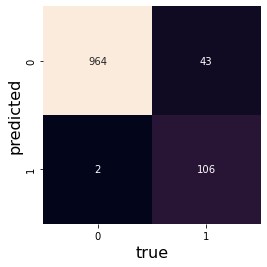

In [88]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pred_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
print('Test:\n')
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16);

The best ``GridSearchCV`` model is empirically no better than using the default hyperparameters.